In [1]:
import os
import sys
from pathlib import Path
from collections import namedtuple
import json

In [2]:
from monai import transforms
from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.networks.schedulers.ddim import DDIMScheduler

In [3]:
import pandas as pd
import numpy as np
import torch


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from colorama import Fore

In [5]:
from CustomTransforms import UnsqueezeTransformd, Random2DSliceTransformd, SliceExtractorTransformd, Sequential2DSliceTransformd

# The image-to-image translation has two steps    
1. Encoding the input image into a latent space with the reversed DDIM sampling scheme
2. Sampling from the latent space using gradient guidance towards the desired class label `y=1` (healthy)

  In order to sample using gradient guidance, we first need to encode the input image in noise by using the reversed DDIM sampling scheme.
  
  We define the number of steps in the noising and denoising process by `L`.

## Global Config/Settings

In [6]:
#Settings
DEBUG = False

DIFFUSION_MODEL_PATH = Path('models/adni_2d_cfg_diffusion_128x128.pt')
EMBEDDING_MODEL_PATH = Path('models/adni_2d_cfg_emb_128x128.pt')
DEVICE = 'mps'
NUM_CLASSES = 5
class_mapping = {
  'CN': 1,
  'EMCI': 2,
  'MCI': 3,
  'LMCI': 4,
  'AD': 5
}
EMBEDDING_DIMENSION = 64


TrainingParams = namedtuple('TrainingParams', [
    'num_iter', 'batch_sz',
    'val_interval', 'val_frac',
    'conditional_dropout',
    'spatial_size'
])
if DEBUG == True:
    TRAINING_PARAMS = TrainingParams(
            num_iter=10, batch_sz=4,
            val_interval=1, val_frac=0.2,
            conditional_dropout=0.15,
            spatial_size=128
        )
else:
    TRAINING_PARAMS = TrainingParams(
            num_iter=2e4, batch_sz=32,
            val_interval=100, val_frac=0.2,
            conditional_dropout=0.15,
            spatial_size=128
        )
    

guidance_scale = 3.0
total_timesteps = 500
latent_space_depth = int(total_timesteps * 0.25)

## Load Trained Models for Inference

In [7]:


diffusion_model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=16,
    with_conditioning=True,
    cross_attention_dim=EMBEDDING_DIMENSION,
).to(DEVICE)
embedding_model = torch.nn.Embedding(num_embeddings=NUM_CLASSES+1, 
                            embedding_dim=EMBEDDING_DIMENSION, 
                            padding_idx=0).to(DEVICE)
diffusion_model.load_state_dict(torch.load(DIFFUSION_MODEL_PATH, map_location=DEVICE))
embedding_model.load_state_dict(torch.load(EMBEDDING_MODEL_PATH, map_location=DEVICE))

embedding_model.eval()
diffusion_model.eval()

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (op):

## Inference Image/Volume Setup

In [8]:
INFERENCE_CHANNEL = 0 #0,1,2
INFERENCE_SLICE = 128//2

inference_json = json.loads('{ \
    "image" : "data/ad/ADNI_127_S_5095_MR_MT1__N3m_Br_20140625124846577_S201196_I432860.nii.gz", \
    "label" : 5 \
}')

In [9]:
print(f'Inference Params: {inference_json}\nSlice Channel: {INFERENCE_CHANNEL}, Slice: {INFERENCE_SLICE}')

Inference Params: {'image': 'data/ad/ADNI_127_S_5095_MR_MT1__N3m_Br_20140625124846577_S201196_I432860.nii.gz', 'label': 5}
Slice Channel: 0, Slice: 64


## Inference Transforms
`SliceExtractorTransformd` extracts `INFERENCE_SLICE` from `INFERENCE_CHANNEL`

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


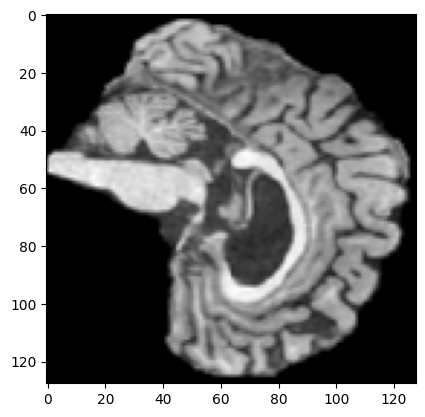

In [10]:
adni_inferer_tx = transforms.Compose([
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=['image']),
    transforms.Orientationd(keys=['image'], axcodes="RAS"),
    # transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
    transforms.CropForegroundd(keys=['image'], source_key="image"),
    transforms.Resized(keys=['image'], spatial_size=(TRAINING_PARAMS.spatial_size, 
                                                    TRAINING_PARAMS.spatial_size,
                                                    TRAINING_PARAMS.spatial_size)),
    # Sequential2DSliceTransformd(keys=['image'], lo=0.35, hi=0.355), #debug
    # Random2DSliceTransformd(keys=['image'], lo=0.35, hi=0.75), # to get a random-slice
    SliceExtractorTransformd(keys=['image'], channel_id=INFERENCE_CHANNEL, slice_id=INFERENCE_SLICE),
    transforms.ScaleIntensityRangePercentilesd(keys=['image'], lower=0, upper=99.5, b_min=0, b_max=1),
    UnsqueezeTransformd(keys=["image"], axis=0),
])
tx_img = adni_inferer_tx(inference_json)['image']
tx_img.shape
plt.imshow(tx_img[0], cmap='gray')

## Move image to MPS/CUDA

In [11]:
inf_img = tx_img[None, ...].float().to(DEVICE)

## Setup Scheduler

In [12]:
scheduler = DDIMScheduler(num_train_timesteps=1000)
scheduler.set_timesteps(num_inference_steps=total_timesteps)
scheduler.clip_sample = False

## Encoding Input "Unhealthy" image to Latent-space of Healthy/CN label

In [13]:
class_embedding = embedding_model(torch.zeros(1).long().to(DEVICE)).unsqueeze(1) # ONE is the class-label for healthy/CN (which is the conditioning we want)
progress_bar = tqdm(range(latent_space_depth))
for i in progress_bar:  # go through the noising process
    t = i
    with torch.no_grad():
        model_output = diffusion_model(inf_img, timesteps=torch.Tensor((t,)).to(inf_img.device), context=class_embedding)
    inf_img, _ = scheduler.reversed_step(model_output, t, inf_img)
    progress_bar.set_postfix({"timestep input": t})

latent_img = inf_img

100%|██████████| 125/125 [00:14<00:00,  8.79it/s, timestep input=124]


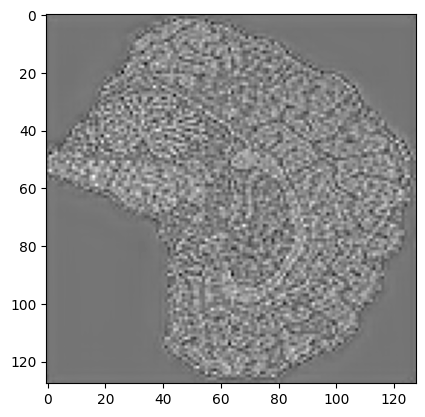

In [14]:
latent_img.shape
plt.imshow(latent_img.cpu()[0,0], cmap='gray')

## Sample from the Latent-space
Decode using Gradient Guidance towards desired class-label `y=1`

In [15]:
conditioning = torch.cat([torch.zeros(1).long(), torch.ones(1).long()], dim=0).to(DEVICE) #(Contioning, Unconditioning)
class_embedding = embedding_model(conditioning).unsqueeze(1)

progress_bar = tqdm(range(latent_space_depth))
for i in progress_bar:  # go through the denoising process
    t = latent_space_depth - i
    inf_img_double = torch.cat([inf_img] * 2)
    with torch.no_grad():
        model_output = diffusion_model(
            inf_img_double, timesteps=torch.Tensor([t, t]).to(inf_img.device), context=class_embedding
        )
    noise_pred_uncond, noise_pred_text = model_output.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    inf_img, _ = scheduler.step(noise_pred, t, inf_img)
    progress_bar.set_postfix({"timestep input": t})
    if DEVICE == 'mps':
        torch.mps.empty_cache()
    elif DEVICE == 'cuda':
        torch.cuda.empty_cache()


100%|██████████| 125/125 [00:27<00:00,  4.55it/s, timestep input=1] 


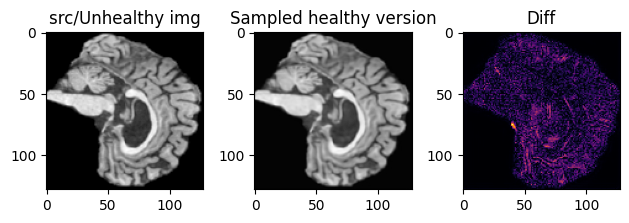

In [16]:
inf_img.shape
diff = abs(tx_img[0] - inf_img.cpu()[0,0])

fig = plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

ax = plt.subplot(1, 3, 1)
plt.imshow(tx_img[0], cmap='gray')
ax.set_title('src/Unhealthy img')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
plt.imshow(inf_img.cpu()[0,0], cmap='gray')
ax.set_title('Sampled healthy version')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
plt.imshow(diff, cmap='inferno')
ax.set_title('Diff')
plt.tight_layout()

## Calculate Image Similarities

In [17]:
x = tx_img.squeeze()
y = inf_img[0].cpu().squeeze()

### Perform contrast normalization

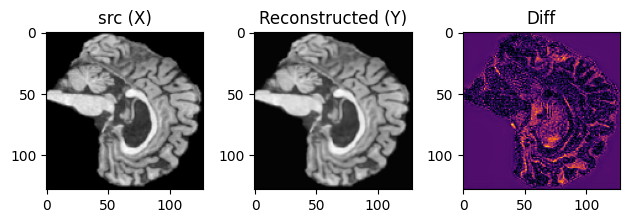

In [18]:
x = (x - x.min()) / (x.max() - x.min())
y = (y - y.min()) / (y.max() - y.min())

fig = plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

ax = plt.subplot(1, 3, 1)
plt.imshow(x, cmap='gray')
ax.set_title('src (X)')
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
plt.imshow(y, cmap='gray')
ax.set_title('Reconstructed (Y)')
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
plt.imshow(abs(x - y), cmap='inferno')
ax.set_title('Diff')
plt.tight_layout()

### scikit SSIM

In [19]:
from skimage.metrics import structural_similarity
scikit_ssim = structural_similarity(x.numpy().astype('float32'), 
                                            y.numpy().astype('float32'), 
                                            multichannel=False, 
                                            win_size=3, data_range=1.0)
print(f'SSIM: {scikit_ssim: .4f}')

SSIM:  0.7224


### piqa image similarities (SSIM, FID, MS-SSIM, LPIPS, VSI)

In [20]:
import piqa
piqa_ssim=piqa.SSIM(n_channels=1)(x.unsqueeze(0).unsqueeze(0), y.unsqueeze(0).unsqueeze(0))
piqa_psnr = piqa.PSNR()(x, y)

#Compute FID
piqa_fid = piqa.FID()
fid_score = piqa_fid(x, y)

#Compute MSID
piqa_msssim = piqa.MS_SSIM(n_channels=1, window_size=8)
msssim_score = piqa_msssim(x.unsqueeze(0).unsqueeze(0), y.unsqueeze(0).unsqueeze(0))

#LPIPS
lpips_score = piqa.LPIPS()(
    torch.cat([x.unsqueeze(0)]*3).unsqueeze(0),
    torch.cat([y.unsqueeze(0)]*3).unsqueeze(0)
)

#Visual Saliency Indicator
vsi_score = piqa.VSI()(
    torch.cat([x.unsqueeze(0)]*3).unsqueeze(0),
    torch.cat([y.unsqueeze(0)]*3).unsqueeze(0)
)

print(f'piqa: \nssim: {piqa_ssim: .4f}\npsnr: {piqa_psnr:.4f}\nfid: {fid_score:.4f}\nmssim: {msssim_score:.4f}\nlpips: {lpips_score:.4f}\nvsi: {vsi_score:.4f}')

piqa: 
ssim:  0.7971
psnr: 34.9984
fid: 0.0209
mssim: 0.9980
lpips: 0.0067
vsi: 0.9962


## Run Inference across all Slices in a certain range

*NOTE: This can take a long time and produce a lot of output*

In [21]:
all_slices_tx = transforms.Compose([
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
            transforms.EnsureTyped(keys=['image']),
            transforms.Orientationd(keys=['image'], axcodes="RAS"),
            # transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
            transforms.CropForegroundd(keys=['image'], source_key="image"),
            transforms.Resized(keys=['image'], spatial_size=(TRAINING_PARAMS.spatial_size, TRAINING_PARAMS.spatial_size, TRAINING_PARAMS.spatial_size)),
            # Sequential2DSliceTransformd(keys=['image'], lo=0.35, hi=0.355), #debug
            Sequential2DSliceTransformd(keys=['image'], lo=0.35, hi=0.75),
            transforms.ScaleIntensityRangePercentilesd(keys=['image'], lower=0, upper=99.5, b_min=0, b_max=1),
            UnsqueezeTransformd(keys=["image"], axis=0),
        ])
seq2DSliceTx: Sequential2DSliceTransformd = all_slices_tx.transforms[all_slices_tx.get_index_of_first(lambda t: isinstance(t, Sequential2DSliceTransformd))]

  (slice_ch, slice_idx)=(0, 44) : [44, 128, 128]
Encoding/Noising input Image to Latent Space ADNI_127_S_5095_MR_MT1__N3m_Br_20140625124846577_S201196_I432860.nii ...


100%|██████████| 125/125 [00:14<00:00,  8.84it/s, timestep input=124]


Sampling from the latent-space using Gradient Guidance towards the desired class label `y=1` (healthy/CN) ...


100%|██████████| 125/125 [00:27<00:00,  4.57it/s, timestep input=1] 


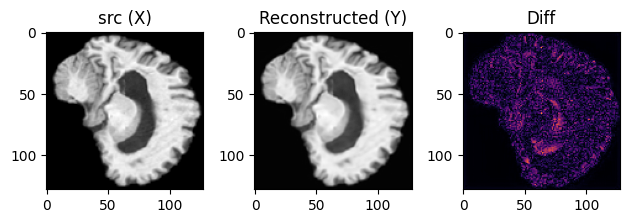

scikit-ssim: 0.7443
piqa: ssim:  0.8192, psnr: 35.4748, fid: 0.0041
mssim: 0.9986, lpips: 0.0075, vsi: 0.9969


In [22]:
scheduler = DDIMScheduler(num_train_timesteps=1000)
yN = 'y'
slice_sim_scores = []
while (yN == 'y' or yN == 'Y' or yN == '') and (seq2DSliceTx.is_next_slice_available == True):
    srcImg = all_slices_tx(inference_json)['image']

    current_img = srcImg[None, ...].float().to(DEVICE)
    scheduler.set_timesteps(num_inference_steps=total_timesteps)

    ## Encoding
    print(f'{Fore.MAGENTA}Encoding/Noising input Image to Latent Space{Fore.WHITE} {Path(inference_json["image"]).stem} ...')
    scheduler.clip_sample = False
    class_embedding = embedding_model(torch.zeros(1).long().to(DEVICE)).unsqueeze(1) # ONE is the class-label for healthy/CN (which is the conditioning we want)
    progress_bar = tqdm(range(latent_space_depth))
    for i in progress_bar:  # go through the noising process
        t = i
        with torch.no_grad():
            model_output = diffusion_model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device), context=class_embedding)
        current_img, _ = scheduler.reversed_step(model_output, t, current_img)
        progress_bar.set_postfix({"timestep input": t})

    latent_img = current_img

    ## Decoding
    print(f'{Fore.MAGENTA}Sampling from the latent-space using Gradient Guidance towards the desired class label `y=1` (healthy/CN) ...{Fore.WHITE}')
    conditioning = torch.cat([torch.zeros(1).long(), torch.ones(1).long()], dim=0).to(DEVICE) #(Contioning, Unconditioning)
    class_embedding = embedding_model(conditioning).unsqueeze(1)

    progress_bar = tqdm(range(latent_space_depth))
    for i in progress_bar:  # go through the denoising process
        t = latent_space_depth - i
        current_img_double = torch.cat([current_img] * 2)
        with torch.no_grad():
            model_output = diffusion_model(
                current_img_double, timesteps=torch.Tensor([t, t]).to(current_img.device), context=class_embedding
            )
        noise_pred_uncond, noise_pred_text = model_output.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        current_img, _ = scheduler.step(noise_pred, t, current_img)
        progress_bar.set_postfix({"timestep input": t})
        if DEVICE == 'mps':
            torch.mps.empty_cache()
        elif DEVICE == 'cuda':
            torch.cuda.empty_cache()
    
    #Calculate metrics
    diff = abs(srcImg.cpu() - current_img[0].cpu()).detach().numpy()
    x = srcImg.cpu().squeeze(0)
    y = current_img[0].cpu().squeeze(0)

    #Perform Contrast normalization
    x = (x-x.min())/(x.max()-x.min())
    y = (y-y.min())/(y.max()-y.min())

    fig = plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    ax = plt.subplot(1, 3, 1)
    plt.imshow(x, cmap='gray')
    ax.set_title('src (X)')
    plt.tight_layout()

    ax = plt.subplot(1, 3, 2)
    plt.imshow(y, cmap='gray')
    ax.set_title('Reconstructed (Y)')
    plt.tight_layout()

    ax = plt.subplot(1, 3, 3)
    plt.imshow(diff[0], cmap='inferno')
    ax.set_title('Diff')
    plt.tight_layout()

    plt.show()

    scikit_ssim = structural_similarity(x.numpy().astype('float32'), 
                                        y.numpy().astype('float32'), 
                                        multichannel=False, 
                                        win_size=3, data_range=1.0)
    #piqa
    piqa_ssim=piqa.SSIM(n_channels=1)(x.unsqueeze(0).unsqueeze(0), y.unsqueeze(0).unsqueeze(0))
    piqa_psnr = piqa.PSNR()(x, y)

    #Compute FID
    piqa_fid = piqa.FID()
    fid_score = piqa_fid(x, y)

    #Compute MSID
    piqa_msssim = piqa.MS_SSIM(n_channels=1, window_size=8)
    msssim_score = piqa_msssim(x.unsqueeze(0).unsqueeze(0), y.unsqueeze(0).unsqueeze(0))

    #LPIPS
    lpips_score = piqa.LPIPS()(
        torch.cat([x.unsqueeze(0)]*3).unsqueeze(0),
        torch.cat([y.unsqueeze(0)]*3).unsqueeze(0)
    )

    #Visual Saliency Indicator
    vsi_score = piqa.VSI()(
        torch.cat([x.unsqueeze(0)]*3).unsqueeze(0),
        torch.cat([y.unsqueeze(0)]*3).unsqueeze(0)
    )

    print(f'scikit-ssim: {Fore.RED}{scikit_ssim:.4f}{Fore.RESET}')
    print(f'piqa: ssim: {Fore.RED}{piqa_ssim: .4f}{Fore.RESET}, psnr: {Fore.RED}{piqa_psnr:.4f}{Fore.RESET}, fid: {Fore.RED}{fid_score:.4f}{Fore.RESET}\nmssim: {Fore.RED}{msssim_score:.4f}{Fore.RESET}, lpips: {Fore.RED}{lpips_score:.4f}{Fore.RESET}, vsi: {Fore.RED}{vsi_score:.4f}{Fore.RESET}')
    slice_str_rep = seq2DSliceTx.curr_slice_str_rep.replace("[", "").replace("]", "").replace(", ", "_")
    slice_sim_scores.append([
            slice_str_rep, 
            scikit_ssim, 
            piqa_ssim.item(), 
            piqa_psnr.item(), 
            fid_score.item(), 
            msssim_score.item(),
            lpips_score.item(),
            vsi_score.item()
        ])

    if DEBUG:
        yN = input("Sample one more slice? Yy/nN ?: ")
